# XGBoost and LightGBM Classifiers

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize
import pickle
import time
import os

In [2]:
print("NOTEBOOK 10: XGBOOST AND LIGHTGBM CLASSIFIERS")

NOTEBOOK 10: XGBOOST AND LIGHTGBM CLASSIFIERS


In [3]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"]=(12,8)

# 2. Load Prepared Datasets

In [4]:
X_train = np.load("../data/processed/ml_ready/X_train_scaled.npy") 
X_test = np.load("../data/processed/ml_ready/X_test_scaled.npy")    
y_train = np.load("../data/processed/ml_ready/y_train.npy")         
y_test = np.load("../data/processed/ml_ready/y_test.npy")           

In [5]:
with open("../data/processed/ml_ready/feature_names.pkl","rb") as f:
    feature_names=pickle.load(f)

with open("../models/label_encoder.pkl","rb") as f:
    label_encoder=pickle.load(f)

In [6]:
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [7]:
print(f"Training samples:{X_train.shape[0]:,}")
print(f"Testing samples:{X_test.shape[0]:,}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes:{len(label_encoder.classes_)} which are {list(label_encoder.classes_)}")

Training samples:1,760
Testing samples:440
Features: 39
Classes:22 which are ['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']


# 3. Algorithm Overview

In [8]:
print("""
GRADIENT BOOSTING ALGORITHMS OVERVIEW
=====================================

XGBOOST (Extreme Gradient Boosting):
- Regularized gradient boosting (L1/L2)
- Handles missing values automatically
- Parallel tree construction
- Built-in cross-validation

LIGHTGBM (Light Gradient Boosting Machine):
- Leaf-wise tree growth (faster)
- Histogram-based algorithm
- Lower memory usage
- Handles large datasets efficiently

Both are state-of-the-art for tabular data!
""")


GRADIENT BOOSTING ALGORITHMS OVERVIEW

XGBOOST (Extreme Gradient Boosting):
- Regularized gradient boosting (L1/L2)
- Handles missing values automatically
- Parallel tree construction
- Built-in cross-validation

LIGHTGBM (Light Gradient Boosting Machine):
- Leaf-wise tree growth (faster)
- Histogram-based algorithm
- Lower memory usage
- Handles large datasets efficiently

Both are state-of-the-art for tabular data!



# 4. XGBoost Classifier

In [9]:
print("Training XGBoost Classifier...")

Training XGBoost Classifier...


In [10]:
n_classes = len(np.unique(y_train))

In [11]:
xgb_params = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'objective': 'multi:softprob',
    'num_class': n_classes,
    'eval_metric': 'mlogloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}


In [12]:
print("Base Parameters")
for k,v in xgb_params.items():
    print(f"{k}: {v}")

Base Parameters
learning_rate: 0.1
max_depth: 6
n_estimators: 100
objective: multi:softprob
num_class: 22
eval_metric: mlogloss
subsample: 0.8
colsample_bytree: 0.8
random_state: 42
n_jobs: -1
verbosity: 0


In [13]:
print("\n Training the XGBoost Classifier with base parameters...")
start=time.time()
xgb_model=XGBClassifier(**xgb_params)
xgb_model.fit(X_train,y_train)
xgb_train_time=time.time()-start
print(f"Training completed in {xgb_train_time:.2f} seconds.")


 Training the XGBoost Classifier with base parameters...
Training completed in 16.14 seconds.


XGBoost Predictions

In [14]:
y_train_pred_xgb=xgb_model.predict(X_train)
y_test_pred_xgb=xgb_model.predict(X_test)
y_test_proba_xgb=xgb_model.predict_proba(X_test)

In [15]:
xgb_train_acc=accuracy_score(y_train,y_train_pred_xgb)
xgb_test_acc=accuracy_score(y_test,y_test_pred_xgb)
xgb_precision=precision_score(y_test,y_test_pred_xgb,average="weighted")
xgb_recall=recall_score(y_test,y_test_pred_xgb,average="weighted")
xgb_f1=f1_score(y_test,y_test_pred_xgb,average="weighted")

In [16]:
print("\n XGBOOST PERFORMANCE METRICS")
print(f"Training Accuracy: {xgb_train_acc*100:.2f} %")
print(f"Testing Accuracy: {xgb_test_acc*100:.2f} %")
print(f"Precision: {xgb_precision*100:.2f} %")
print(f"Recall: {xgb_recall*100:.2f} %")
print(f"F1-Score: {xgb_f1*100:.2f} %")
print(f"Overfitting Gap: {(xgb_train_acc - xgb_test_acc)*100:.2f} %")


 XGBOOST PERFORMANCE METRICS
Training Accuracy: 100.00 %
Testing Accuracy: 98.86 %
Precision: 98.91 %
Recall: 98.86 %
F1-Score: 98.86 %
Overfitting Gap: 1.14 %


# 4.1 XGBoost Hyperparameter Tuning

In [17]:
print("\nHyperparameter Tuning for XGBoost Classifier using GridSearchCV")


Hyperparameter Tuning for XGBoost Classifier using GridSearchCV


In [18]:
xgb_param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [100, 200]
}

In [19]:
xgb_grid = GridSearchCV(
    XGBClassifier(
        objective='multi:softprob',
        num_class=n_classes,
        eval_metric='mlogloss',
        random_state=42,
        verbosity=0
    ),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)


In [20]:
start=time.time()
xgb_grid.fit(X_train, y_train)
xgb_grid_time=time.time()-start

In [21]:
print(f"\n GridSearchCV completed in {xgb_grid_time:.2f} seconds.")
print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"Best CV Accuracy: {xgb_grid.best_score_*100:.2f} %")


 GridSearchCV completed in 94.76 seconds.
Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}
Best CV Accuracy: 98.64 %


Best XGBoost Model

In [22]:
best_xgb=xgb_grid.best_estimator_
y_test_pred_xgb_best=best_xgb.predict(X_test)
y_test_proba_xgb_best=best_xgb.predict_proba(X_test)
xgb_best_acc=accuracy_score(y_test,y_test_pred_xgb_best)
print(f"\nXGBoost Best Model Test Accuracy: {xgb_best_acc*100:.2f} %")


XGBoost Best Model Test Accuracy: 98.64 %


# 5. LightGBM Classifier

In [23]:
print("Training lightGBM Classifier...")

Training lightGBM Classifier...


In [24]:
lgbm_params = {
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'multiclass',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}


In [25]:
print("\n Base Parameters for LightGBM")
for k,v in lgbm_params.items():
    print(f"{k}: {v}")


 Base Parameters for LightGBM
num_leaves: 31
learning_rate: 0.1
n_estimators: 100
objective: multiclass
random_state: 42
n_jobs: -1
verbose: -1


In [26]:
print("\n Training the LightGBM Classifier with base parameters...")
start=time.time()
lgbm_model=LGBMClassifier(**lgbm_params)
lgbm_model.fit(X_train,y_train)
lgbm_train_time=time.time()-start


 Training the LightGBM Classifier with base parameters...


In [27]:
print(f"Training completed in {lgbm_train_time:.2f} seconds.")

Training completed in 4.90 seconds.


LightGBM Predictions

In [28]:
y_train_pred_lgbm=lgbm_model.predict(X_train)
y_test_pred_lgbm=lgbm_model.predict(X_test)
y_test_proba_lgbm=lgbm_model.predict_proba(X_test)

In [29]:
lgbm_train_acc=accuracy_score(y_train,y_train_pred_lgbm)
lgbm_test_acc=accuracy_score(y_test,y_test_pred_lgbm)
lgbm_precision=precision_score(y_test,y_test_pred_lgbm,average="weighted")
lgbm_recall=recall_score(y_test,y_test_pred_lgbm,average="weighted")
lgbm_f1=f1_score(y_test,y_test_pred_lgbm,average="weighted")

In [30]:
print("nLightGBM PERFORMANCE METRICS")
print(f"Training Accuracy: {lgbm_train_acc*100:.2f} %")
print(f"Testing Accuracy: {lgbm_test_acc*100:.2f} %")
print(f"Precision: {lgbm_precision*100:.2f} %")
print(f"Recall: {lgbm_recall*100:.2f} %")
print(f"F1-Score: {lgbm_f1*100:.2f} %")
print(f"Overfitting Gap: {(lgbm_train_acc - lgbm_test_acc)*100:.2f} %") 

nLightGBM PERFORMANCE METRICS
Training Accuracy: 100.00 %
Testing Accuracy: 98.86 %
Precision: 98.94 %
Recall: 98.86 %
F1-Score: 98.86 %
Overfitting Gap: 1.14 %


# 5.1 LightGBM Hyperparameter Tuning

In [31]:
print("\nHyperparameter Tuning for LightGBM Classifier using GridSearchCV")


Hyperparameter Tuning for LightGBM Classifier using GridSearchCV


In [32]:
lgb_param_grid={
    "num_leaves": [20, 31, 50],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [100, 200]
}

In [33]:
lgbm_grid = GridSearchCV(
    LGBMClassifier(objective='multiclass', random_state=42, verbose=-1),
    lgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)

In [34]:
start=time.time()
lgbm_grid.fit(X_train, y_train)
lgbm_grid_time=time.time()-start

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [35]:
print(f"\n GridSearchCV completed in {lgbm_grid_time:.2f} seconds.")
print(f"Best Parameters: {lgbm_grid.best_params_}")
print(f"Best CV Accuracy: {lgbm_grid.best_score_*100:.2f} %")


 GridSearchCV completed in 279.65 seconds.
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 20}
Best CV Accuracy: 98.58 %


Best LightGBM Model

In [36]:
best_lgbm=lgbm_grid.best_estimator_
y_test_pred_lgbm_best=best_lgbm.predict(X_test)
y_test_proba_lgbm_best=best_lgbm.predict_proba(X_test)
lgbm_best_acc=accuracy_score(y_test,y_test_pred_lgbm_best)

In [37]:
print(f"\n Best LightGBM Model Test Accuracy: {lgbm_best_acc*100:.2f} %")


 Best LightGBM Model Test Accuracy: 98.41 %


# 6. Model Comparison

In [38]:
print("XGBOOST VS LIGHTGBM COMPARISON")

XGBOOST VS LIGHTGBM COMPARISON


In [39]:
comparison = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'],
    'XGBoost': [f'{xgb_best_acc*100:.2f}%', 
                f'{precision_score(y_test, y_test_pred_xgb_best, average="weighted")*100:.2f}%',
                f'{recall_score(y_test, y_test_pred_xgb_best, average="weighted")*100:.2f}%',
                f'{f1_score(y_test, y_test_pred_xgb_best, average="weighted")*100:.2f}%',
                f'{xgb_grid_time:.2f}s'],
    'LightGBM': [f'{lgbm_best_acc*100:.2f}%',
                 f'{precision_score(y_test, y_test_pred_lgbm_best, average="weighted")*100:.2f}%',
                 f'{recall_score(y_test, y_test_pred_lgbm_best, average="weighted")*100:.2f}%',
                 f'{f1_score(y_test, y_test_pred_lgbm_best, average="weighted")*100:.2f}%',
                 f'{lgbm_grid_time:.2f}s']
})



In [40]:
print(comparison.to_string(index=False))

       Metric XGBoost LightGBM
Test Accuracy  98.64%   98.41%
    Precision  98.68%   98.48%
       Recall  98.64%   98.41%
     F1-Score  98.63%   98.41%
Training Time  94.76s  279.65s


# 7. Feature Importance Comparison

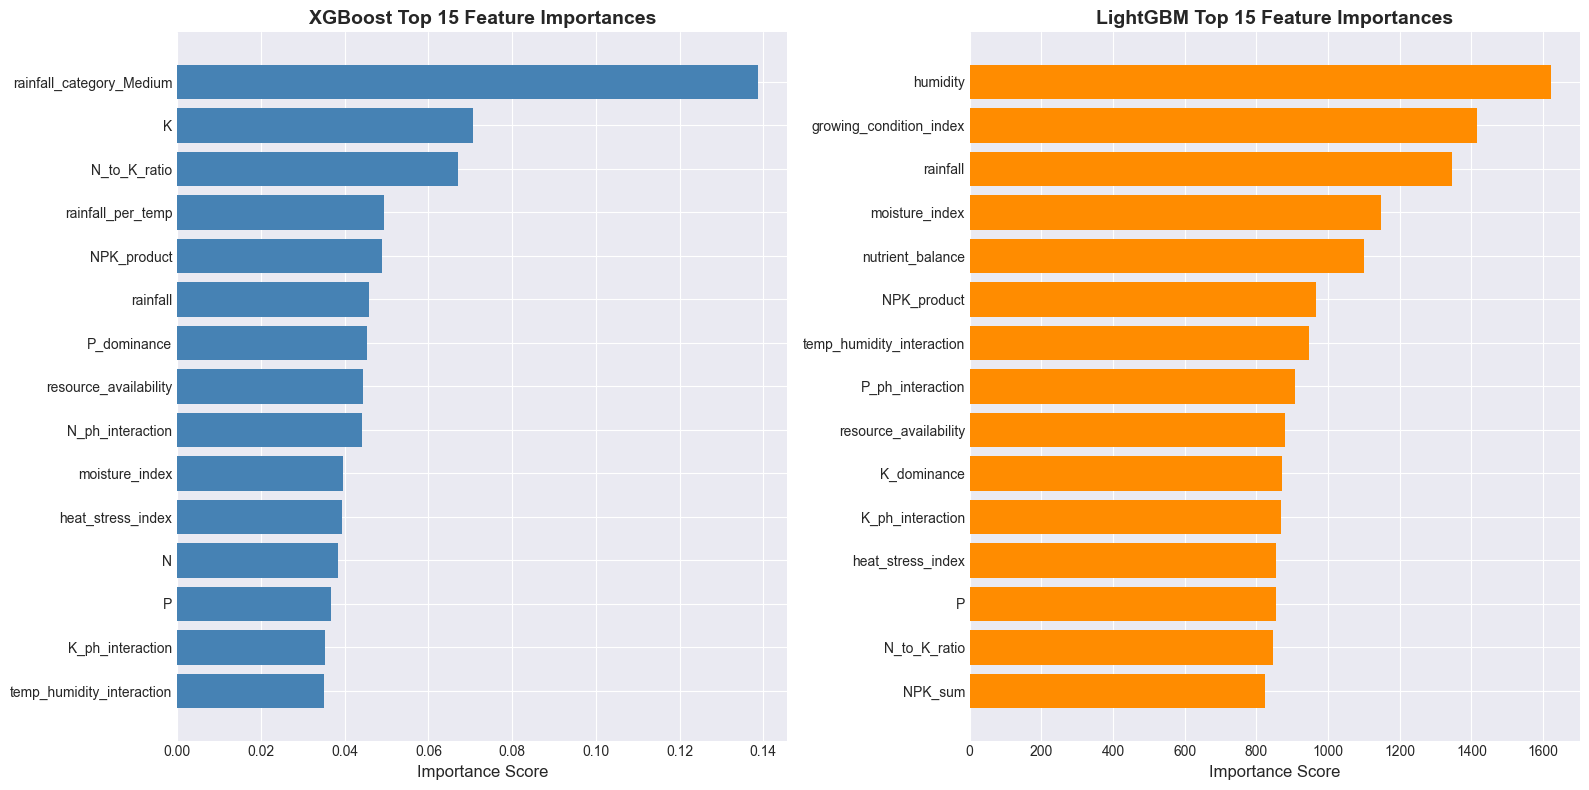

Saved: ../data/visualizations/44_xgb_lgbm_feature_importance.png


In [41]:
fig,axes=plt.subplots(1,2,figsize=(16,8))

xgb_importances=best_xgb.feature_importances_
xgb_idx=np.argsort(xgb_importances)[-15:]
axes[0].barh(range(15),xgb_importances[xgb_idx],color="steelblue")
axes[0].set_yticks(range(15))
axes[0].set_yticklabels([feature_names[i] for i in xgb_idx])
axes[0].set_title("XGBoost Top 15 Feature Importances",fontweight="bold",fontsize=14)
axes[0].set_xlabel("Importance Score",fontsize=12)


lgbm_importances=best_lgbm.feature_importances_
lgbm_idx=np.argsort(lgbm_importances)[-15:]
axes[1].barh(range(15),lgbm_importances[lgbm_idx],color="darkorange")
axes[1].set_yticks(range(15))
axes[1].set_yticklabels([feature_names[i] for i in lgbm_idx])
axes[1].set_title("LightGBM Top 15 Feature Importances",fontweight="bold",fontsize=14)
axes[1].set_xlabel("Importance Score",fontsize=12)

plt.tight_layout()
plt.savefig('../data/visualizations/44_xgb_lgbm_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../data/visualizations/44_xgb_lgbm_feature_importance.png")

# 8. Confusion Matrices

Confusion matrix for xgboost

In [42]:
cm_xgb=confusion_matrix(y_test, y_test_pred_xgb_best)
cm_xgb_norm=cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]

Confusion matrix for LightGBM

In [43]:
cm_lgbm = confusion_matrix(y_test, y_test_pred_lgbm_best)
cm_lgbm_norm = cm_lgbm.astype('float') / cm_lgbm.sum(axis=1)[:, np.newaxis]

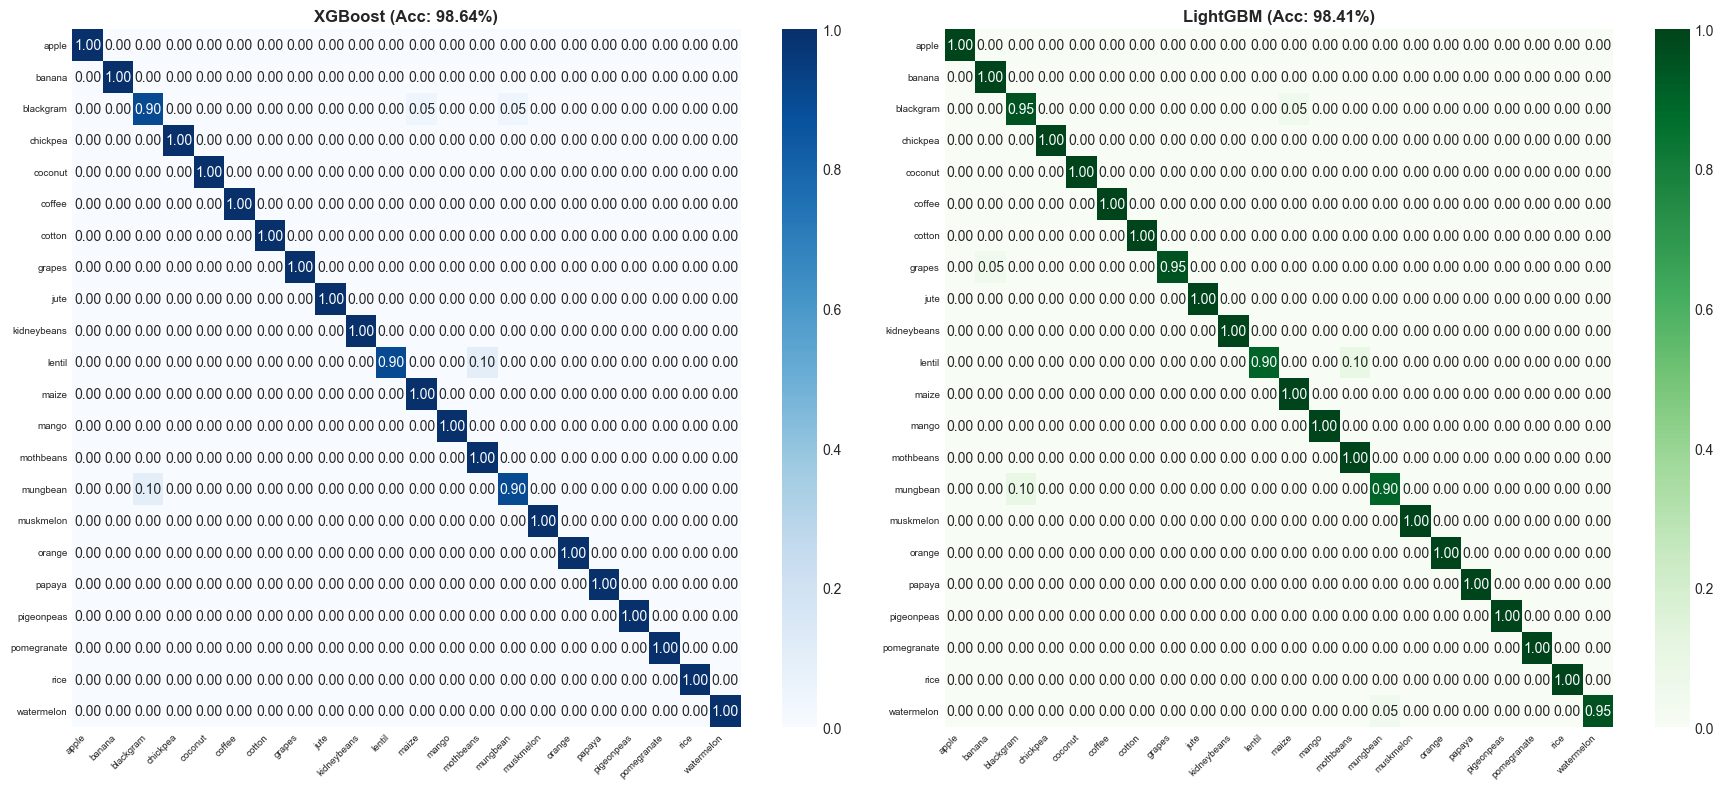

Saved: ../data/visualizations/45_xgb_lgbm_confusion_matrices.png


In [46]:
fig,axes=plt.subplots(1,2,figsize=(18,8))

#For XGBoost
sns.heatmap(cm_xgb_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title(f'XGBoost (Acc: {xgb_best_acc*100:.2f}%)', fontweight='bold')
axes[0].tick_params(axis='both', labelsize=7)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

#For LightGBM
sns.heatmap(cm_lgbm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title(f'LightGBM (Acc: {lgbm_best_acc*100:.2f}%)', fontweight='bold')
axes[1].tick_params(axis='both', labelsize=7)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../data/visualizations/45_xgb_lgbm_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../data/visualizations/45_xgb_lgbm_confusion_matrices.png")

# 9. Save Models

In [47]:
print("Saving Models")

Saving Models


In [48]:
os.makedirs("../models/boosting_models", exist_ok=True)

Save XGBoost

In [49]:
with open('../models/boosting_models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)
print("Saved:../models/boosting_models/xgboost_model.pkl")

Saved:../models/boosting_models/xgboost_model.pkl


 Save LightGBM

In [50]:
with open('../models/boosting_models/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(best_lgbm, f)
print("Saved:../models/boosting_models/lightgbm_model.pkl")

Saved:../models/boosting_models/lightgbm_model.pkl


Save Results

In [51]:
results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'Best_Params': [str(xgb_grid.best_params_), str(lgbm_grid.best_params_)],
    'Test_Accuracy': [xgb_best_acc, lgbm_best_acc],
    'Training_Time': [xgb_grid_time, lgbm_grid_time]
})

In [52]:
results_df.to_csv('../data/results/xgb_lgbm_comparison.csv', index=False)
print("Saved: ../data/results/xgb_lgbm_comparison.csv")

Saved: ../data/results/xgb_lgbm_comparison.csv


In [53]:
print("NOTEBOOK 10 COMPLETED!")

winner = "XGBoost" if xgb_best_acc > lgbm_best_acc else "LightGBM"
best_acc = max(xgb_best_acc, lgbm_best_acc)

print(f"""
SUMMARY:
- XGBoost Accuracy: {xgb_best_acc*100:.2f}%
- LightGBM Accuracy: {lgbm_best_acc*100:.2f}%
- Winner: {winner} ({best_acc*100:.2f}%)
""")

#But both are excellent choices for crop recommendation!

NOTEBOOK 10 COMPLETED!

SUMMARY:
- XGBoost Accuracy: 98.64%
- LightGBM Accuracy: 98.41%
- Winner: XGBoost (98.64%)

